In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2

In [2]:
BASE_DIR = '../data/'
TRAIN_DIR = BASE_DIR + '/train_v2/'
TEST_DIR = BASE_DIR + '/test_v2/'

In [3]:
masks = pd.read_csv(os.path.join(BASE_DIR, 'train_ship_segmentations_v2.csv'))
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [4]:
masks[not_empty].ImageId.nunique()

42556

In [5]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
masks.drop(['ships'], axis=1, inplace=True)
print(unique_img_ids.loc[unique_img_ids.ships>=2].head())

          ImageId  ships  has_ship
3   000194a2d.jpg      5       1.0
5   00021ddc3.jpg      9       1.0
6   0002756f7.jpg      2       1.0
11  000532683.jpg      2       1.0
15  0005d01c8.jpg      2       1.0


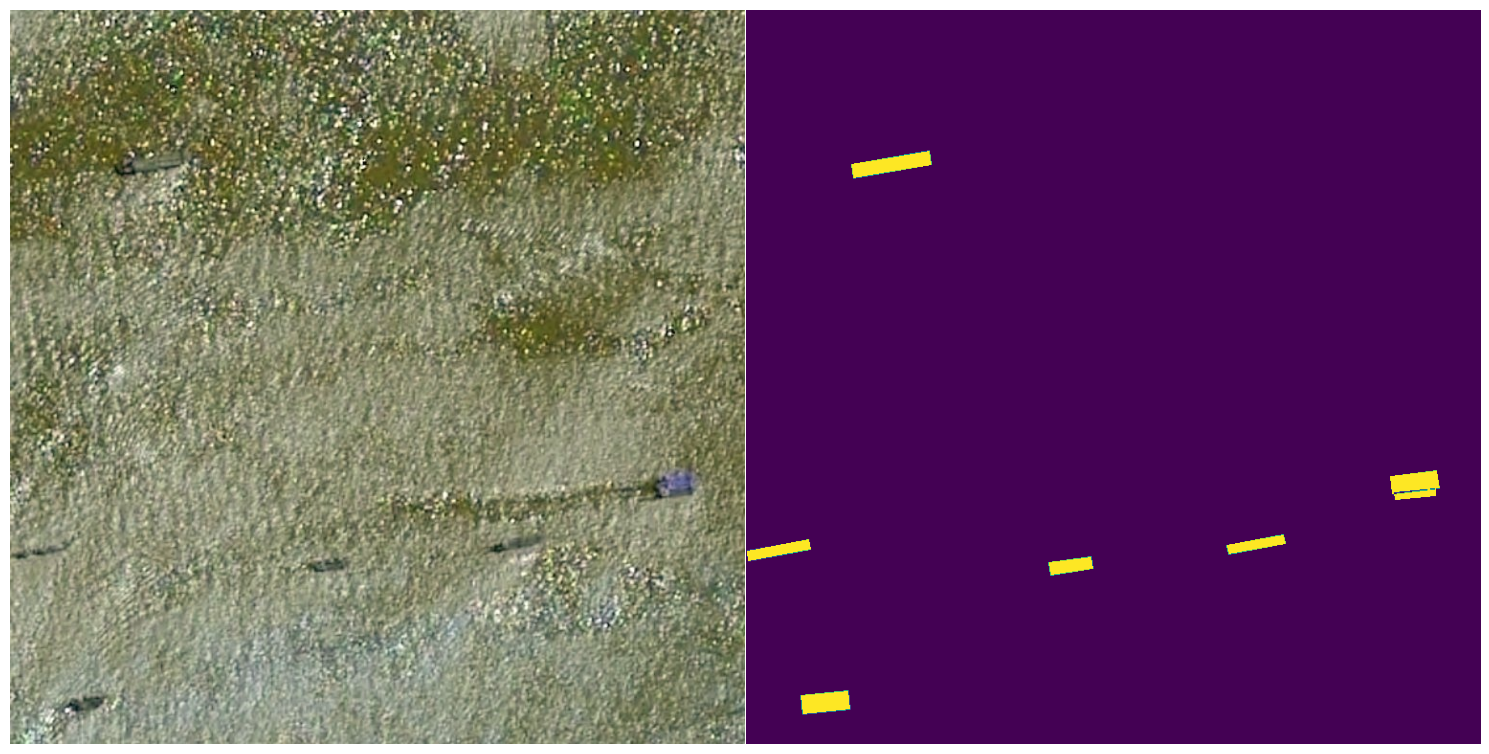

In [6]:
def _rle_to_mask(rle_list, width, height):
    mask = np.zeros(width * height, dtype=np.uint8)

    for rle in rle_list:
        array = np.asarray([int(x) for x in rle.split()])
        starts = array[::2]
        lengths = array[1::2]
        for start, length in zip(starts, lengths):
            mask[start : start + length] = 1

    return mask.reshape((height, width), order="F")


ImageId = "003520305.jpg"

img = cv2.imread(TRAIN_DIR + ImageId, cv2.COLOR_BGR2RGB)
img_masks = masks.loc[masks["ImageId"] == ImageId, "EncodedPixels"].tolist()
mask = _rle_to_mask(img_masks, 768, 768)
fig, axarr = plt.subplots(1, 2, figsize=(15, 40))
axarr[0].axis("off")
axarr[1].axis("off")
axarr[0].imshow(img)
axarr[1].imshow(mask)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [7]:
root_dir = ROOT_DIR_TRAIN = "../data/train_v2"
from PIL import Image

def _load_images(image_name):
    # Check if the folder path exists
    if not os.path.exists(root_dir):
        raise ValueError(f"The folder path '{root_dir}' does not exist.")

    if os.path.isfile(os.path.join(root_dir, image_name)):
        # Open the image file using PIL with the 'with' statement
        with Image.open(os.path.join(root_dir, image_name)) as image:
            # copy image
            image = image.copy()

    return image


image = np.array(_load_images(ImageId)).astype(np.float32) / 255.0

In [8]:
df = pd.read_csv("../data_cleared/uniqueAllLabels.csv", index_col=0)

In [9]:
def _rle_to_mask(rle, width=768, height=768):
    mask = np.zeros(width * height, dtype=np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[::2]
    lengths = array[1::2]
    for start, length in zip(starts, lengths):
        mask[start : start + length] = 1
    return mask.reshape((height, width), order='F')


def _load_masks(image_name):
    image_row = df.loc[df["ImageId"] == image_name]
    if not pd.isnull(image_row.iloc[0]["EncodedPixels"]):
        temp_masks = []
        for rle in image_row["EncodedPixels"]:
            mask = _rle_to_mask(rle)
            temp_masks.append(mask)
        masks = np.sum(temp_masks, axis=0)
        return masks / 1.0
    else:
        # Return an empty mask if there are no positive masks for the image
        # will be used during fine-tuning on full-sized images and inference
        return np.zeros((768, 768)) / 1.0

In [10]:
mask = _load_masks(ImageId)

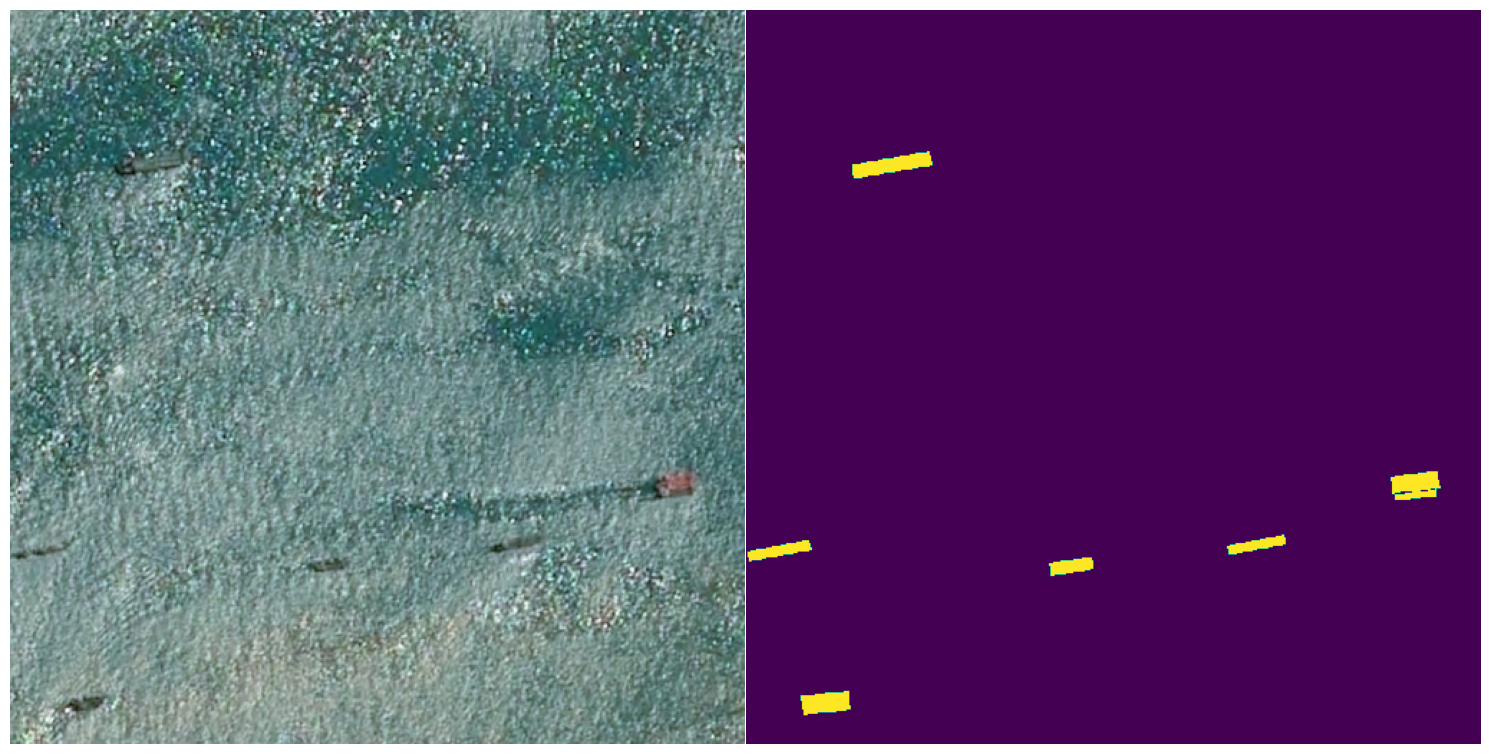

In [11]:
from albumentations.pytorch import ToTensorV2
import albumentations as A

TRANSFORM_TRAIN = A.Compose(
    [
        A.Resize(512, 512),
        A.RandomBrightnessContrast(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=90, p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        ToTensorV2(),
    ]
)
# Assuming 'image' is your input image
augmented = TRANSFORM_TRAIN(image=image, mask=mask)
augmented_image = augmented["image"]
augmented_mask = augmented["mask"]

# Transpose back to (height, width, channels) for visualization
augmented_image = np.transpose(augmented_image, (1, 2, 0))


fig, axarr = plt.subplots(1, 2, figsize=(15, 40))
axarr[0].axis("off")
axarr[1].axis("off")
axarr[0].imshow(augmented_image)
axarr[1].imshow(augmented_mask)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

Inference result to check images:

In [19]:
output = pd.read_csv("../runs/output.csv", index_col=0)
output.head()

,ImageId,EncodedPixels
0,34e173e41.jpg,532689 4 533455 8 534224 8 534993 7 535762 7 5...
1,b8ed98f85.jpg,NaN
2,8b6d36215.jpg,NaN
3,fe512aa9e.jpg,485617 1
4,e0b9eeb7b.jpg,NaN


In [24]:
output_nnull = output[~output.EncodedPixels.isna()].reset_index(drop=True)

In [25]:
output_nnull

,ImageId,EncodedPixels
0,34e173e41.jpg,532689 4 533455 8 534224 8 534993 7 535762 7 5...
1,fe512aa9e.jpg,485617 1
2,3a7c57df9.jpg,50876 13 51641 22 52408 26 53175 31 53209 9 53...
3,3e26d0be3.jpg,578497 3 579261 9 580027 12 580794 14 581560 1...
4,df35c8f2e.jpg,344560 2
...,...,...
4286,8932f1a52.jpg,230503 13 231271 17 232038 22 232806 25 233574...
4287,fb4e2cbd6.jpg,503826 7 504592 10 505359 11 506125 14 506892 ...
4288,d8d1bdc4e.jpg,209165 4 209928 11 210689 20 211451 27 212212 ...
4289,c7b10873e.jpg,51082 2 51849 3 52616 4 53384 4 54152 2


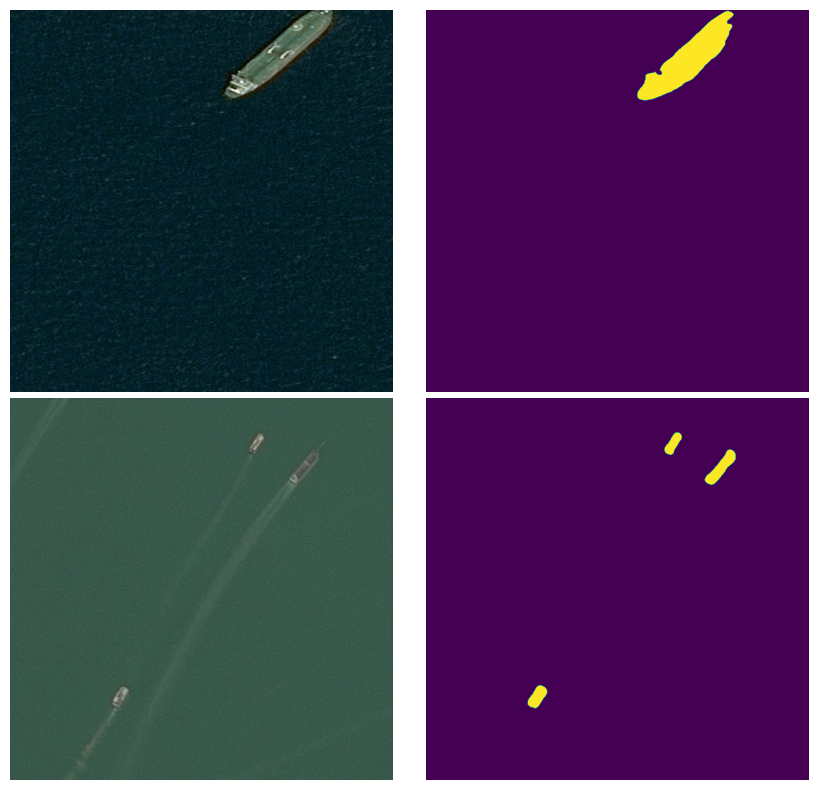

In [26]:
def _rle_to_mask(rle, width=768, height=768):
    mask = np.zeros(width * height, dtype=np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[::2]
    lengths = array[1::2]
    for start, length in zip(starts, lengths):
        mask[start : start + length] = 1
    return mask.reshape((height, width))

# Assuming output is a DataFrame
with Image.open(os.path.join(TEST_DIR, output.ImageId[4288])) as image:
    image1 = image.copy()
mask1 = _rle_to_mask(output.EncodedPixels[4288])

with Image.open(os.path.join(TEST_DIR, output.ImageId[1713])) as image:
    image2 = image.copy()
mask2 = _rle_to_mask(output.EncodedPixels[1713])

fig, axarr = plt.subplots(2, 2, figsize=(9, 8))
axarr[0, 0].axis("off")
axarr[0, 1].axis("off")
axarr[1, 1].axis("off")
axarr[1, 0].axis("off")

axarr[0, 0].imshow(image1)
axarr[0, 1].imshow(mask1)
axarr[1, 0].imshow(image2)
axarr[1, 1].imshow(mask2)

plt.subplots_adjust(hspace=0, wspace=0)  # Set wspace to zero
plt.tight_layout(h_pad=0.4, w_pad=0.2)
plt.show()
